In [3]:
%load_ext autoreload
%autoreload 2

In [18]:

import numpy as np
import vehicle_carpooling.solution as sol


NB_STEPS = 2
NB_NODES = 4
NB_PASSENGERS = 2
NB_ENTITY = 2
NB_VEHICLES = 1
VEHICLE_CAPACITY = 1

#   0
#  / \
# 1 - 2
# \ /
#  3

PATH_MAP = np.array([[1, 1, 1, 0],
                    [1, 1, 1, 1],
                    [1, 1, 1, 1],
                    [0, 1, 1, 1]])
PASSENGER_START_POINTS = np.array([0, 1])
PASSENGER_FINISH_POINTS = np.array([1, 2])
VEHICLE_START_POINTS = np.array([0, 1])

RIDE_PATH_PARAM = {
    "nb_steps": NB_STEPS,
    "nb_nodes": NB_NODES,
    "nb_passengers": NB_PASSENGERS,
    "passenger_start_points": PASSENGER_START_POINTS,
    "passenger_finish_points": PASSENGER_FINISH_POINTS,
    "path_map": PATH_MAP,
    "nb_vehicles": NB_VEHICLES,
    "vehicle_capacity": VEHICLE_CAPACITY
}

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

solved_iterations = []
for a in alphas:
    print(f"test for a = {a}")
    avg_it_list = []
    for _ in range(10):
        it = 0
        checked = False
        ride_path = sol.RidePath(**RIDE_PATH_PARAM)
        while not checked:
            ride_path.shuffle(a)
            if ride_path.check_constraint():
                checked = True
                avg_it_list.append(it)
            it += 1
    solved_iterations.append(avg_it_list)


test for a = 0.1
test for a = 0.2
test for a = 0.3
test for a = 0.4
test for a = 0.5
test for a = 0.6
test for a = 0.7
test for a = 0.8
test for a = 0.9
test for a = 1


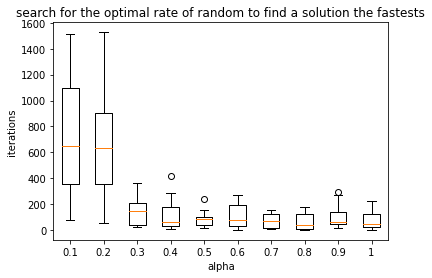

In [19]:
#plot solved iterations with scatter box according to alpha
import matplotlib.pyplot as plt
plt.boxplot(solved_iterations, labels=alphas)
plt.xlabel("alpha")
plt.ylabel("iterations")
plt.title("search for the optimal rate of random to find a solution the fastests")
plt.show()

In [27]:
best = np.mean(solved_iterations[0])
best_alpha = 0.1
for l in solved_iterations:
    print(f"average iterations for alpha = {alphas[solved_iterations.index(l)]} is {np.mean(l)}")
    if np.mean(l) < best:
        best = np.mean(l)
        best_alpha = alphas[solved_iterations.index(l)]
print(f"best alpha is {best_alpha} for mean {best}")

average iterations for alpha = 0.1 is 75444.6
average iterations for alpha = 0.2 is 51377.5
average iterations for alpha = 0.3 is 42896.9
average iterations for alpha = 0.4 is 40378.2
average iterations for alpha = 0.5 is 54081.8
average iterations for alpha = 0.6 is 27781.3
average iterations for alpha = 0.7 is 25788.5
average iterations for alpha = 0.8 is 21711.5
average iterations for alpha = 0.9 is 25890.4
average iterations for alpha = 1 is 27063.0
best alpha is 0.8 for mean 21711.5


To build the first solution maybe it's better optimizing it
then we can only use neighbour that flip paths of ride_path then make changes to other matrixes and check if conditions still works then check if it's better or not

other plan :
we optimize as we build:    
    we build a working step for each matrix 
    then with neighbour and flipping find the best


Other plan :
we change the conditions to have them linear with 1 meeting to conditions and 0 not meeting to conditions while 0.5 only half meet the conditions. With this we can have gradient and then optimize it normaly. Only downside is that it might not always meet all conditions

for each step:
> ### we build a random step
> for each passenger :
>- we get it's position
>- we select the next step
>- we check if it's possible (nb of cars)
>- we select a new car if no car is available
>- we register in ride_vehicle and drive the car informations

> we check the score

> we do 100 iterations on neighbour:
>- we get the neighbour
>- if the score is better we keep it
>- else we keep the old one
    
score = current_score + distance to arrival

current_score = nb_car_used_this_step

we minimize score

TODO:
- build a function to check if a move is legal (changements in other matrixes and mostly limit number of cars and capacity and paths)
- build a funciton to get a neighbour
  - build a swap function -> change 2 provided paths on ride_path
  - get all possible swaps ? or at least check if one is possible
- build the score function

**Building step by step has the flaw of not having the big picture and it is hard to make neighbour**

The solution might be to try to linearize the problem and then use gradient descent
So the first step would be to create a score on the conditions and then try to optimize it
I want to see if by getting neighbour of a solution with good conditions score if we can get a better score


The best thing that could happend is to find a way to link the values of all matrixes directly

In [19]:
import numpy as np
import vehicle_carpooling.solution as sol
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s',
                    level=logging.DEBUG, datefmt='%I:%M:%S')



NB_STEPS = 2
NB_NODES = 4
NB_PASSENGERS = 2
NB_ENTITY = 2
NB_VEHICLES = 1
VEHICLE_CAPACITY = 1

#  0
# / \
# 1 - 2
# \ /
#  3

PATH_MAP = np.array([[1, 1, 1, 0],
                    [1, 1, 1, 1],
                    [1, 1, 1, 1],
                    [0, 1, 1, 1]])
PASSENGER_START_POINTS = np.array([0, 1])
PASSENGER_FINISH_POINTS = np.array([1, 2])
VEHICLE_START_POINTS = np.array([0, 1])

RIDE_PATH_PARAM = {
    "nb_steps": NB_STEPS,
    "nb_nodes": NB_NODES,
    "nb_passengers": NB_PASSENGERS,
    "passenger_start_points": PASSENGER_START_POINTS,
    "passenger_finish_points": PASSENGER_FINISH_POINTS,
    "path_map": PATH_MAP,
    "nb_vehicles": NB_VEHICLES,
    "vehicle_capacity": VEHICLE_CAPACITY
}



ride_path = sol.RidePath(**RIDE_PATH_PARAM)
print(ride_path.solution)
neighbor = ride_path.get_neighbor(1,5)
print(neighbor.solution)
        

12:28:27 DEBUG:Neighbor: Swap node 0
12:28:27 DEBUG:Neighbor: Swap node 0
12:28:27 DEBUG:Neighbor: Swap node 3
12:28:27 DEBUG:Neighbor: Swap node 3


[[[-1 -1]
  [-1 -1]]

 [[-1 -1]
  [-1 -1]]]
[[[-1  0]
  [ 0  0]]

 [[-1  3]
  [ 3  3]]]


# New tests with violation counter and neighbour

In [54]:

import numpy as np
import math
import vehicle_carpooling.solution as sol
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s',
                    level=logging.INFO, datefmt='%I:%M:%S')
logger = logging.getLogger("vehicle_carpooling.solution")
logger.setLevel(logging.DEBUG)

NB_STEPS = 2
NB_NODES = 4
NB_PASSENGERS = 2
NB_ENTITY = 2
NB_VEHICLES = 1
VEHICLE_CAPACITY = 1

#  0
# / \
# 1 - 2
# \ /
#  3

PATH_MAP = np.array([[1, 1, 1, 0],
                    [1, 1, 1, 1],
                    [1, 1, 1, 1],
                    [0, 1, 1, 1]])
PASSENGER_START_POINTS = np.array([0, 1])
PASSENGER_FINISH_POINTS = np.array([1, 2])
VEHICLE_START_POINTS = np.array([0, 1])

RIDE_PATH_PARAM = {
    "nb_steps": NB_STEPS,
    "nb_nodes": NB_NODES,
    "nb_passengers": NB_PASSENGERS,
    "passenger_start_points": PASSENGER_START_POINTS,
    "passenger_finish_points": PASSENGER_FINISH_POINTS,
    "path_map": PATH_MAP,
    "nb_vehicles": NB_VEHICLES,
    "vehicle_capacity": VEHICLE_CAPACITY
}

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

#alphas = [0.4,0.6,0.8]
solved_iterations = []
for a in alphas:
    print(f"test for a = {a}")
    avg_it_list = []
    for _ in range(100):
        print(f"test Nb{_}")
        it = 0
        checked = False
        ride_path = sol.RidePath(**RIDE_PATH_PARAM)
        ride_path.shuffle(a)
        neighbor = sol.RidePath(**RIDE_PATH_PARAM)
        ride_path.check_constraint()
        while not checked :
            temperature = math.ceil(
                max(1, neighbor.nb_nodes / 2 * math.exp(-it/100)))
            # at each step we try 10 neighbors and keep the best
            for i in range(10):
                neighbor = ride_path.get_neighbor(a,temperature)
                neighbor.check_constraint()
                if neighbor.violation_count < ride_path.violation_count:
                    ride_path = neighbor
            it += 1
            if ride_path.violation_count == 0:
                checked = True
                avg_it_list.append(it)
            if it > 100:
                # reset
                ride_path = sol.RidePath(**RIDE_PATH_PARAM)
                ride_path.shuffle(a)
                it = 0
                print("reset")
    print(f"Constraints : {ride_path.check_constraint()}, nb violations : {ride_path.violation_count}")
    solved_iterations.append(avg_it_list)


test for a = 0.1
test Nb0
reset
test Nb1
test Nb2
reset
test Nb3
reset
test Nb4
reset
test Nb5
test Nb6
reset
test Nb7
test Nb8
reset
test Nb9
reset
test Nb10
test Nb11
reset
test Nb12
test Nb13
reset
test Nb14
reset
test Nb15
reset
test Nb16
reset
test Nb17
test Nb18
reset
test Nb19
reset
test Nb20
test Nb21
reset
test Nb22
test Nb23
test Nb24
reset
test Nb25
test Nb26
reset
test Nb27
reset
test Nb28
test Nb29
reset
test Nb30
reset
test Nb31
reset
test Nb32
test Nb33
test Nb34
test Nb35
reset
test Nb36
test Nb37
reset
test Nb38
reset
test Nb39
reset
test Nb40
reset
test Nb41
test Nb42
reset
test Nb43
reset
test Nb44
test Nb45
test Nb46
test Nb47
reset
test Nb48
reset
test Nb49
reset
test Nb50
test Nb51
reset
test Nb52
reset
test Nb53
reset
test Nb54
reset
test Nb55
reset
test Nb56
reset
test Nb57
test Nb58
reset
test Nb59
reset
test Nb60
reset
test Nb61
reset
test Nb62
test Nb63
test Nb64
test Nb65
reset
test Nb66
reset
test Nb67
reset
test Nb68
reset
test Nb69
test Nb70
reset
test Nb

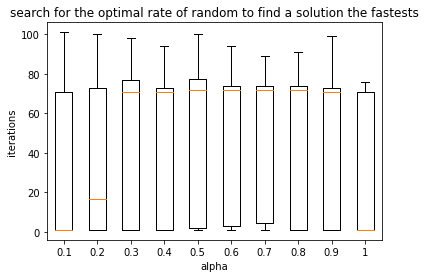

In [55]:
#plot solved iterations with scatter box according to alpha
import matplotlib.pyplot as plt
plt.boxplot(solved_iterations, labels=alphas)
plt.xlabel("alpha")
plt.ylabel("iterations")
plt.title("search for the optimal rate of random to find a solution the fastests")
plt.show()


### same tests with shuffle instead of neighbour

In [56]:

import numpy as np
import math
import vehicle_carpooling.solution as sol
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s',
                    level=logging.INFO, datefmt='%I:%M:%S')
logger = logging.getLogger("vehicle_carpooling.solution")
logger.setLevel(logging.DEBUG)

NB_STEPS = 2
NB_NODES = 4
NB_PASSENGERS = 2
NB_ENTITY = 2
NB_VEHICLES = 1
VEHICLE_CAPACITY = 1

#  0
# / \
# 1 - 2
# \ /
#  3

PATH_MAP = np.array([[1, 1, 1, 0],
                    [1, 1, 1, 1],
                    [1, 1, 1, 1],
                    [0, 1, 1, 1]])
PASSENGER_START_POINTS = np.array([0, 1])
PASSENGER_FINISH_POINTS = np.array([1, 2])
VEHICLE_START_POINTS = np.array([0, 1])

RIDE_PATH_PARAM = {
    "nb_steps": NB_STEPS,
    "nb_nodes": NB_NODES,
    "nb_passengers": NB_PASSENGERS,
    "passenger_start_points": PASSENGER_START_POINTS,
    "passenger_finish_points": PASSENGER_FINISH_POINTS,
    "path_map": PATH_MAP,
    "nb_vehicles": NB_VEHICLES,
    "vehicle_capacity": VEHICLE_CAPACITY
}

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

solved_iterations = []
for a in alphas:
    print(f"test for a = {a}")
    avg_it_list = []
    for _ in range(100):
        print(f"test Nb{_}")
        it = 0
        checked = False
        ride_path = sol.RidePath(**RIDE_PATH_PARAM)
        ride_path.shuffle(a)
        neighbor = sol.RidePath(**RIDE_PATH_PARAM)
        ride_path.check_constraint()
        while not checked:
            rate = math.ceil(
                max(1, neighbor.nb_nodes / 2 * math.exp(-it/10000)))
            neighbor = sol.RidePath(**RIDE_PATH_PARAM)
            neighbor.shuffle(a)
            neighbor.check_constraint()
            if neighbor.violation_count < ride_path.violation_count:
                ride_path = neighbor
            it += 1
            if ride_path.violation_count == 0:
                checked = True
                avg_it_list.append(it)
            if it > 20000:
                # reset
                ride_path = sol.RidePath(**RIDE_PATH_PARAM)
                ride_path.shuffle(a)
                it = 0
                print("reset")
    print(
        f"Constraints : {ride_path.check_constraint()}, nb violations : {ride_path.violation_count}")
    solved_iterations.append(avg_it_list)


test for a = 0.1
test Nb0
test Nb1
test Nb2
test Nb3
test Nb4
test Nb5
test Nb6
test Nb7
test Nb8
test Nb9
test Nb10
test Nb11
test Nb12
test Nb13
test Nb14
test Nb15
test Nb16
test Nb17
test Nb18
test Nb19
test Nb20
test Nb21
test Nb22
test Nb23
test Nb24
test Nb25
test Nb26
test Nb27
test Nb28
test Nb29
test Nb30
test Nb31
test Nb32
test Nb33
test Nb34
test Nb35
test Nb36
test Nb37
test Nb38
test Nb39
test Nb40
test Nb41
test Nb42
test Nb43
test Nb44
test Nb45
test Nb46
test Nb47
test Nb48
test Nb49
test Nb50
test Nb51
test Nb52
test Nb53
test Nb54
test Nb55
test Nb56
test Nb57
test Nb58
test Nb59
test Nb60
test Nb61
test Nb62
test Nb63
test Nb64
test Nb65
test Nb66
test Nb67
test Nb68
test Nb69
test Nb70
test Nb71
test Nb72
test Nb73
test Nb74
test Nb75
test Nb76
test Nb77
test Nb78
test Nb79
test Nb80
test Nb81
test Nb82
test Nb83
test Nb84
test Nb85
test Nb86
test Nb87
test Nb88
test Nb89
test Nb90
test Nb91
test Nb92
test Nb93
test Nb94
test Nb95
test Nb96
test Nb97
test Nb98
tes

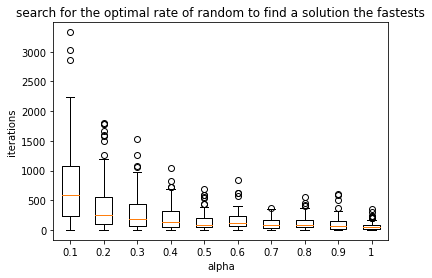

In [57]:
#plot solved iterations with scatter box according to alpha
import matplotlib.pyplot as plt
plt.boxplot(solved_iterations, labels=alphas)
plt.xlabel("alpha")
plt.ylabel("iterations")
plt.title("search for the optimal rate of random to find a solution the fastests")
plt.show()


# let's try on a bigger map with both neighbour and shuffle

In [14]:

import numpy as np
import math
import vehicle_carpooling.solution as sol
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s',
                    level=logging.INFO, datefmt='%I:%M:%S')
logger = logging.getLogger("vehicle_carpooling.solution")
logger.setLevel(logging.DEBUG)

NB_STEPS = 2
NB_NODES = 16
NB_PASSENGERS = 10
NB_ENTITY = 2
NB_VEHICLES = 10
VEHICLE_CAPACITY = 1

# 0-1-2-3
# | | | |
# 4-5-6-7
# | | | |
# 8-9-10-11   
# | | | |
# 12-13-14-15


PATH_MAP = np.zeros((16, 16))
for i in range(16):
    PATH_MAP[i, i] = 1
    if i % 4 != 3:
        PATH_MAP[i, i+1] = 1
        PATH_MAP[i+1, i] = 1
    if i < 12:
        PATH_MAP[i, i+4] = 1
        PATH_MAP[i+4, i] = 1
        
    
PASSENGER_START_POINTS = np.array([0, 1, 3, 4, 1, 2, 3, 4, 1, 2])
PASSENGER_FINISH_POINTS = np.array([1, 2, 5, 6, 2, 3, 4, 5, 2, 3])
VEHICLE_START_POINTS = np.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

RIDE_PATH_PARAM = {
    "nb_steps": NB_STEPS,
    "nb_nodes": NB_NODES,
    "nb_passengers": NB_PASSENGERS,
    "passenger_start_points": PASSENGER_START_POINTS,
    "passenger_finish_points": PASSENGER_FINISH_POINTS,
    "path_map": PATH_MAP,
    "nb_vehicles": NB_VEHICLES,
    "vehicle_capacity": VEHICLE_CAPACITY
}

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

alphas = [0.4, 0.6, 0.8]
solved_iterations = []
for a in alphas:
    print(f"test for a = {a}")
    avg_it_list = []
    for _ in range(1):
        print(f"test Nb{_}")
        it = 0
        checked = False
        ride_path = sol.RidePath(**RIDE_PATH_PARAM)
        ride_path.shuffle(a)
        neighbor = sol.RidePath(**RIDE_PATH_PARAM)
        ride_path.check_constraint()
        while not checked:
            rate = math.ceil(
                max(1, neighbor.nb_nodes / 2 * math.exp(-it/100)))
            # at each step we try 10 neighbors and keep the best
            for i in range(10):
                neighbor = ride_path.get_neighbor(a, rate)
                neighbor.check_constraint()
                if neighbor.violation_count < ride_path.violation_count:
                    ride_path = neighbor
            it += 1
            if ride_path.violation_count == 0:
                checked = True
                avg_it_list.append(it)
                print(it)
            if it > 100:
                # reset
                ride_path = sol.RidePath(**RIDE_PATH_PARAM)
                ride_path.shuffle(a)
                ride_path.check_constraint()
                it = 0
                print("reset")
    print(
        f"Constraints : {ride_path.check_constraint()}, nb violations : {ride_path.violation_count}")
    solved_iterations.append(avg_it_list)


test for a = 0.4
test Nb0
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset
reset

KeyboardInterrupt: 

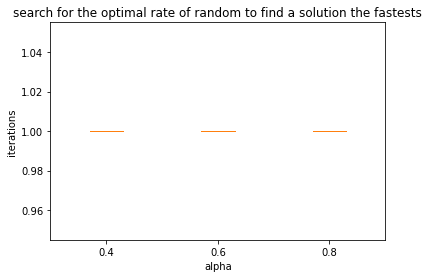

In [51]:
#plot solved iterations with scatter box according to alpha
import matplotlib.pyplot as plt
plt.boxplot(solved_iterations, labels=alphas)
plt.xlabel("alpha")
plt.ylabel("iterations")
plt.title("search for the optimal rate of random to find a solution the fastests")
plt.show()


### Shuffle

it was working fine with more nodes so I added more passengers and vehicles

It seems that scaling the number of passenger or the number of steps will be the biggest issue
- One more passenger adds nb_steps more variables
- One more step adds nb_passengers more variables

In [15]:

import numpy as np
import math
import vehicle_carpooling.solution as sol
import logging

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s',
                    level=logging.INFO, datefmt='%I:%M:%S')
logger = logging.getLogger("vehicle_carpooling.solution")
logger.setLevel(logging.DEBUG)

NB_STEPS = 2
NB_NODES = 16
NB_PASSENGERS = 10
NB_ENTITY = 2
NB_VEHICLES = 10
VEHICLE_CAPACITY = 1

# 0-1-2-3
# | | | |
# 4-5-6-7
# | | | |
# 8-9-10-11
# | | | |
# 12-13-14-15

PATH_MAP = np.zeros((16, 16))
for i in range(16):
    PATH_MAP[i, i] = 1
    if i % 4 != 3:
        PATH_MAP[i, i+1] = 1
        PATH_MAP[i+1, i] = 1
    if i < 12:
        PATH_MAP[i, i+4] = 1
        PATH_MAP[i+4, i] = 1
PASSENGER_START_POINTS = np.array([0, 1,3,4,1,2,3,4,1,2])
PASSENGER_FINISH_POINTS = np.array([1, 2,5,6,2,3,4,5,2,3])
VEHICLE_START_POINTS = np.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

RIDE_PATH_PARAM = {
    "nb_steps": NB_STEPS,
    "nb_nodes": NB_NODES,
    "nb_passengers": NB_PASSENGERS,
    "passenger_start_points": PASSENGER_START_POINTS,
    "passenger_finish_points": PASSENGER_FINISH_POINTS,
    "path_map": PATH_MAP,
    "nb_vehicles": NB_VEHICLES,
    "vehicle_capacity": VEHICLE_CAPACITY
}

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
alphas = [0.4, 0.6, 0.8]
solved_iterations = []
for a in alphas:
    print(f"test for a = {a}")
    avg_it_list = []
    for _ in range(1):
        print(f"test Nb{_}")
        it = 0
        checked = False
        ride_path = sol.RidePath(**RIDE_PATH_PARAM)
        ride_path.shuffle(a)
        neighbor = sol.RidePath(**RIDE_PATH_PARAM)
        ride_path.check_constraint()
        while not checked:
            rate = math.ceil(
                max(1, neighbor.nb_nodes / 2 * math.exp(-it/10000)))
            neighbor = sol.RidePath(**RIDE_PATH_PARAM)
            neighbor.shuffle(a)
            neighbor.check_constraint()
            if neighbor.violation_count < ride_path.violation_count:
                ride_path = neighbor
            it += 1
            if ride_path.violation_count == 0:
                checked = True
                avg_it_list.append(it)
            if it > 20000:
                # reset
                ride_path = sol.RidePath(**RIDE_PATH_PARAM)
                ride_path.shuffle(a)
                ride_path.check_constraint()
                it = 0
                print("reset")
    print(
        f"Constraints : {ride_path.check_constraint()}, nb violations : {ride_path.violation_count}")
    solved_iterations.append(avg_it_list)


test for a = 0.4
test Nb0
reset


KeyboardInterrupt: 

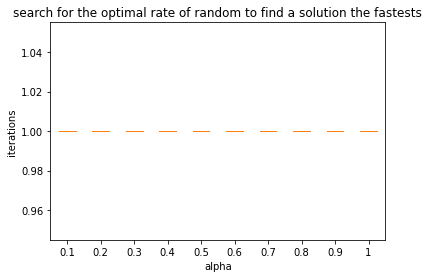

In [35]:
#plot solved iterations with scatter box according to alpha
import matplotlib.pyplot as plt
plt.boxplot(solved_iterations, labels=alphas)
plt.xlabel("alpha")
plt.ylabel("iterations")
plt.title("search for the optimal rate of random to find a solution the fastests")
plt.show()


## Let's check with computed solutions via trees

In [5]:

import numpy as np
import vehicle_carpooling.solution as sol
import vehicle_carpooling.example_generator.generator as ge
import cProfile
config = 3

if config == 1:
    NB_STEPS = 2
    NB_NODES = 4
    NB_PASSENGERS = 2
    NB_ENTITY = 2
    NB_VEHICLES = 1
    VEHICLE_CAPACITY = 1

    #   0
    #  / \
    # 1 - 2
    #  \ /
    #   3

    PATH_MAP = np.array([[1, 1, 1, 0],
                        [1, 1, 1, 1],
                        [1, 1, 1, 1],
                        [0, 1, 1, 1]])
    PASSENGER_START_POINTS = np.array([0, 1])
    PASSENGER_FINISH_POINTS = np.array([1, 2])
    VEHICLE_START_POINTS = np.array([0, 1])

    RIDE_PATH_PARAM = {
        "nb_steps": NB_STEPS,
        "nb_nodes": NB_NODES,
        "nb_passengers": NB_PASSENGERS,
        "passenger_start_points": PASSENGER_START_POINTS,
        "passenger_finish_points": PASSENGER_FINISH_POINTS,
        "path_map": PATH_MAP,
        "nb_vehicles": NB_VEHICLES,
        "vehicle_capacity": VEHICLE_CAPACITY
}

if config == 2:
    NB_STEPS = 4
    NB_NODES = 16
    NB_PASSENGERS = 10
    NB_ENTITY = 2
    NB_VEHICLES = 2
    VEHICLE_CAPACITY = 4

    # 0-1-2-3
    # | | | |
    # 4-5-6-7
    # | | | |
    # 8-9-10-11
    # | | | |
    # 12-13-14-15

    PATH_MAP = np.zeros((16, 16))
    for i in range(16):
        PATH_MAP[i, i] = 1
        if i % 4 != 3:
            PATH_MAP[i, i+1] = 1
            PATH_MAP[i+1,i] = 1
        if i < 12:
            PATH_MAP[i, i+4] = 1
            PATH_MAP[i+4,i] = 1
    PASSENGER_START_POINTS = np.array([0, 1, 3, 4, 1, 2, 3, 4, 1, 2])
    PASSENGER_FINISH_POINTS = np.array([1, 2, 5, 6, 2, 3, 4, 5, 2, 3])
    VEHICLE_START_POINTS = np.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])

    RIDE_PATH_PARAM = {
        "nb_steps": NB_STEPS,
        "nb_nodes": NB_NODES,
        "nb_passengers": NB_PASSENGERS,
        "passenger_start_points": PASSENGER_START_POINTS,
        "passenger_finish_points": PASSENGER_FINISH_POINTS,
        "path_map": PATH_MAP,
        "nb_vehicles": NB_VEHICLES,
        "vehicle_capacity": VEHICLE_CAPACITY
    }



if config==3:
    n = 6
    RIDE_PATH_PARAM = {
        "nb_steps": 4 * n,#should be minimum n-1 + n-1 where n is the number of nodes (sum of side edges)
        "nb_nodes": n * n,
        "nb_passengers": 50,
        "passenger_start_points": None,
        "passenger_finish_points": None,
        "path_map": None,
        "nb_vehicles": 25,
        "vehicle_capacity": 4
    }

    RIDE_PATH_PARAM["passenger_start_points"], RIDE_PATH_PARAM["passenger_finish_points"] = ge.generate_start_finish_nodes(
        RIDE_PATH_PARAM["nb_passengers"], RIDE_PATH_PARAM["nb_nodes"])
    RIDE_PATH_PARAM["path_map"] = ge.generate_manhattan_path_map(
        RIDE_PATH_PARAM["nb_nodes"])
    
    

ride_paths = []
profiler = cProfile.Profile()
profiler.enable()
it = 0
checked = False
print("Initialization...")
ride_path = sol.RidePath(**RIDE_PATH_PARAM)
print("Initialization finished")
while not checked:
    it += 1
    ride_path.tree_suffle()
    #print([ride_path.check_constraint(i==1,i==2,i==3,i==4) for i in range(1,5)])
    if ride_path.check_constraint():
        checked = True
        ride_paths.append(ride_path)
    if it > 100:
        print("overflow")
        break
profiler.disable()
profiler.print_stats(sort='time')
profiler.dump_stats('profiles/profile.prof')

Initialization...


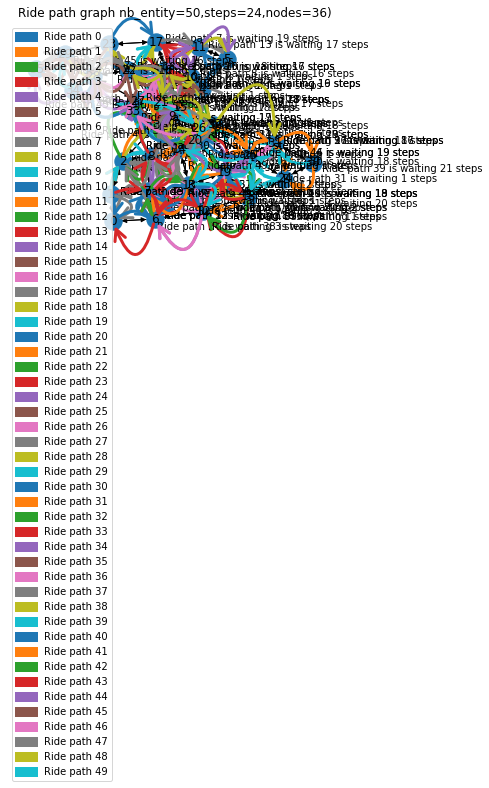

[[1 2]
 [2 3]
 [3 9]
 [9 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]
 [8 8]]
[ 4  1 12 27 33  6 15 17 10 31  1 18  6 11 26 16  2 10  2  1 16 18 33  6
  8 14 25 31 21 18 25 26  6 22 33  3 31 13 12 30 18 21 21  1 25 29 26 35
 10 27]
[11  8 16 12 35 27 34  6 29 17  7 24 16 16  6 35 13  1  5 17 17 14  3 11
 12 20 11 25  4 29 28 24 12  0 34 34  6  9 19 18 12  7 16 19  5 33 16  2
 31 12]


In [3]:
ride_paths[0].graph()
print(ride_path.solution[1])
print(ride_path.passenger_start_points)
print(ride_path.passenger_finish_points)

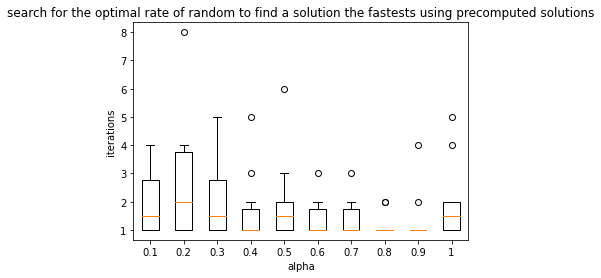

In [41]:
#plot solved iterations with scatter box according to alpha
import matplotlib.pyplot as plt
plt.boxplot(solved_iterations, labels=alphas)
plt.xlabel("alpha")
plt.ylabel("iterations")
plt.title("search for the optimal rate of random to find a solution the fastests using precomputed solutions")
plt.show()


In [42]:
best = np.mean(solved_iterations[0])
best_alpha = 0.1
for l in solved_iterations:
    print(
        f"average iterations for alpha = {alphas[solved_iterations.index(l)]} is {np.mean(l)}")
    if np.mean(l) < best:
        best = np.mean(l)
        best_alpha = alphas[solved_iterations.index(l)]
print(f"best alpha is {best_alpha} for mean {best}")


average iterations for alpha = 0.1 is 1.9
average iterations for alpha = 0.2 is 2.7
average iterations for alpha = 0.3 is 2.0
average iterations for alpha = 0.4 is 1.7
average iterations for alpha = 0.5 is 2.0
average iterations for alpha = 0.6 is 1.4
average iterations for alpha = 0.7 is 1.4
average iterations for alpha = 0.8 is 1.2
average iterations for alpha = 0.9 is 1.4
average iterations for alpha = 1 is 2.0
best alpha is 0.8 for mean 1.2
